In [1]:
import numpy as np
import soundfile as sf
import scipy.signal as signal
import matplotlib.pyplot as plt

<>:62: SyntaxWarning: invalid escape sequence '\F'
<>:63: SyntaxWarning: invalid escape sequence '\F'
<>:62: SyntaxWarning: invalid escape sequence '\F'
<>:63: SyntaxWarning: invalid escape sequence '\F'
C:\Users\Muhammad Husnain\AppData\Local\Temp\ipykernel_5972\3711328476.py:62: SyntaxWarning: invalid escape sequence '\F'
  wav_file = "D:\FYP\Final Project\SegmentedAudio\DroneA_d20_h10_seg2.wav"  # Path to your .wav file
C:\Users\Muhammad Husnain\AppData\Local\Temp\ipykernel_5972\3711328476.py:63: SyntaxWarning: invalid escape sequence '\F'
  calibration_file = "D:\FYP\Final Project\calibration_file.txt"  # Path to the uploaded calibration file


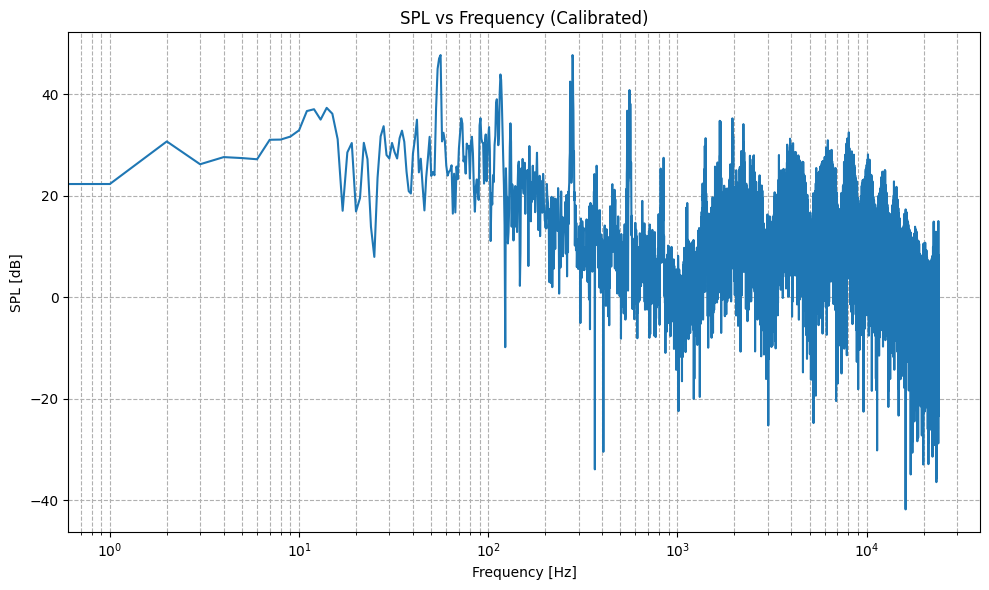

In [2]:
import numpy as np
import soundfile as sf
import scipy.signal as signal
import matplotlib.pyplot as plt

def read_calibration_file(calibration_path):
    """
    Reads the UMIK-1 calibration file (frequency in Hz and dB correction).
    Returns interpolating function for calibration.
    """
    # Load calibration file data
    data = np.loadtxt(calibration_path, skiprows=1)  # Skip first row with Sens Factor
    freq, correction = data[:, 0], data[:, 1]
    # Interpolation for calibration curve
    calibration_interp = np.interp
    return lambda f: calibration_interp(f, freq, correction)

def compute_spl_db(fft_magnitude, ref=20e-6):
    """
    Convert magnitude to SPL in dB. ref is 20 µPa.
    """
    return 20 * np.log10(fft_magnitude / ref + 1e-20)  # Avoid log(0)

def process_audio_file(wav_path, calibration_path):
    # Load audio file
    data, samplerate = sf.read(wav_path)
    
    # If stereo, convert to mono
    if data.ndim > 1:
        data = np.mean(data, axis=1)

    # Apply a Hann window
    window = np.hanning(len(data))
    data_windowed = data * window

    # FFT
    fft_result = np.fft.rfft(data_windowed)
    freqs = np.fft.rfftfreq(len(data), 1/samplerate)
    fft_magnitude = np.abs(fft_result) / len(data_windowed)

    # Load and interpolate calibration correction
    calib_func = read_calibration_file(calibration_path)
    calib_correction_db = calib_func(freqs)

    # Convert to SPL in dB
    spl = compute_spl_db(fft_magnitude)
    spl_calibrated = spl + calib_correction_db  # Apply calibration

    return freqs, spl_calibrated

def plot_spl_vs_frequency(freqs, spl_calibrated):
    plt.figure(figsize=(10, 6))
    plt.semilogx(freqs, spl_calibrated)
    plt.title('SPL vs Frequency (Calibrated)')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('SPL [dB]')
    plt.grid(True, which='both', ls='--')
    plt.tight_layout()
    plt.show()

# === Usage ===
wav_file = "D:\FYP\Final Project\SegmentedAudio\DroneA_d20_h10_seg2.wav"  # Path to your .wav file
calibration_file = "D:\FYP\Final Project\calibration_file.txt"  # Path to the uploaded calibration file

freqs, spl_calibrated = process_audio_file(wav_file, calibration_file)
plot_spl_vs_frequency(freqs, spl_calibrated)

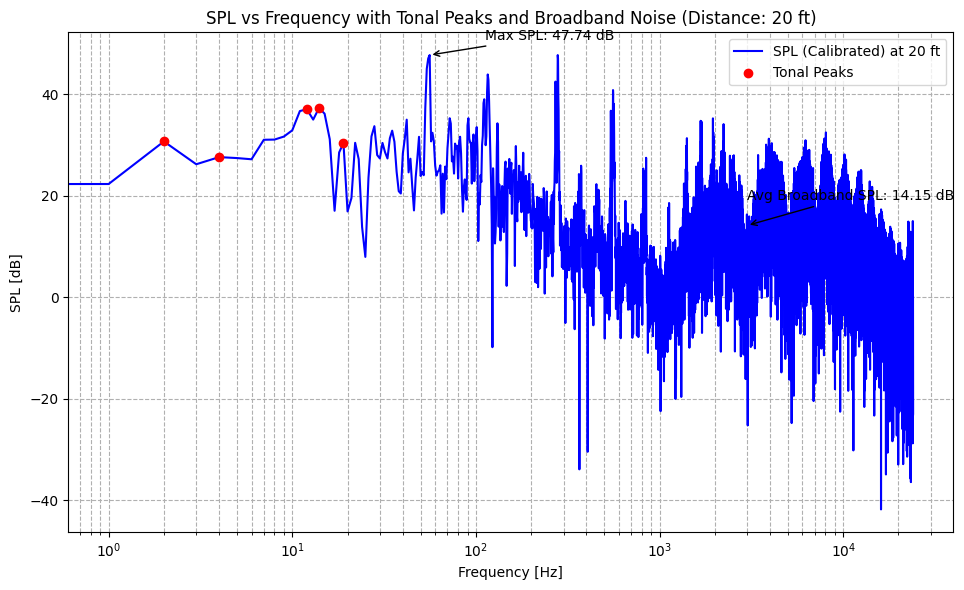

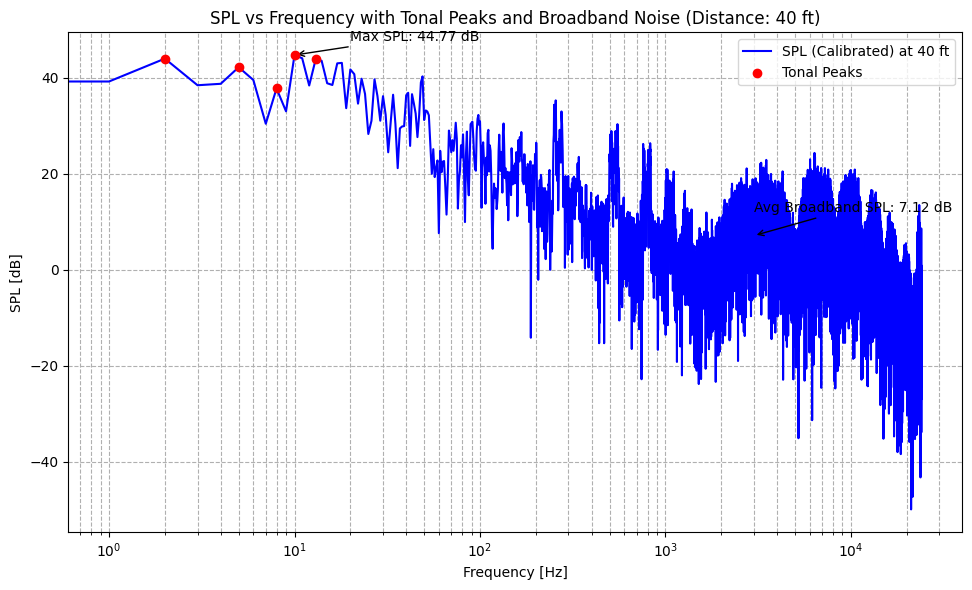

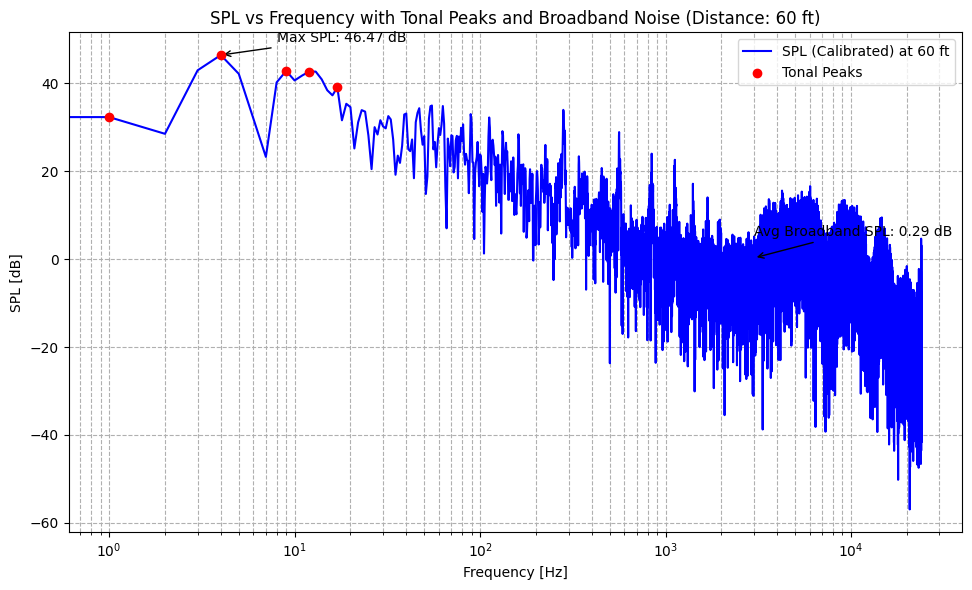

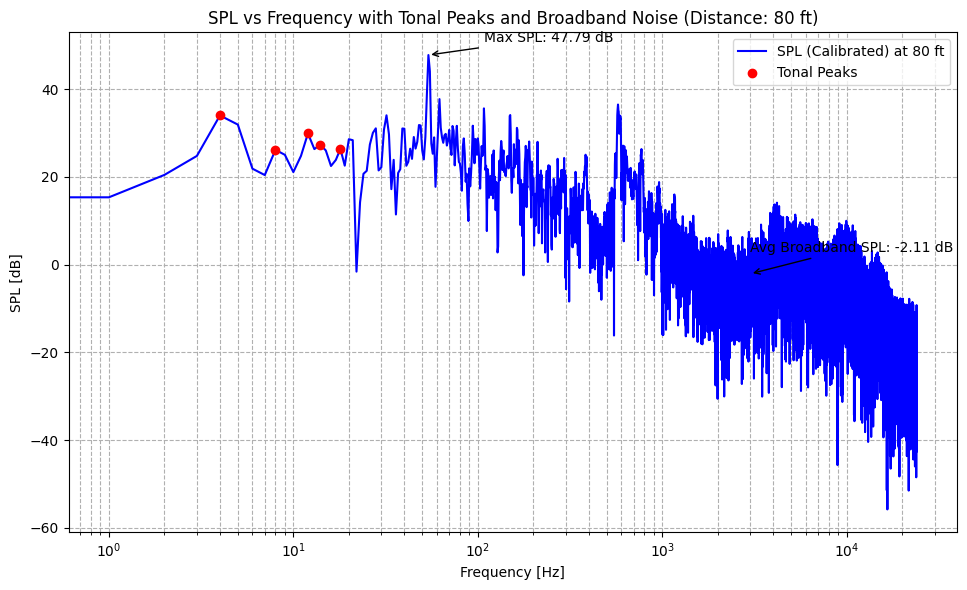

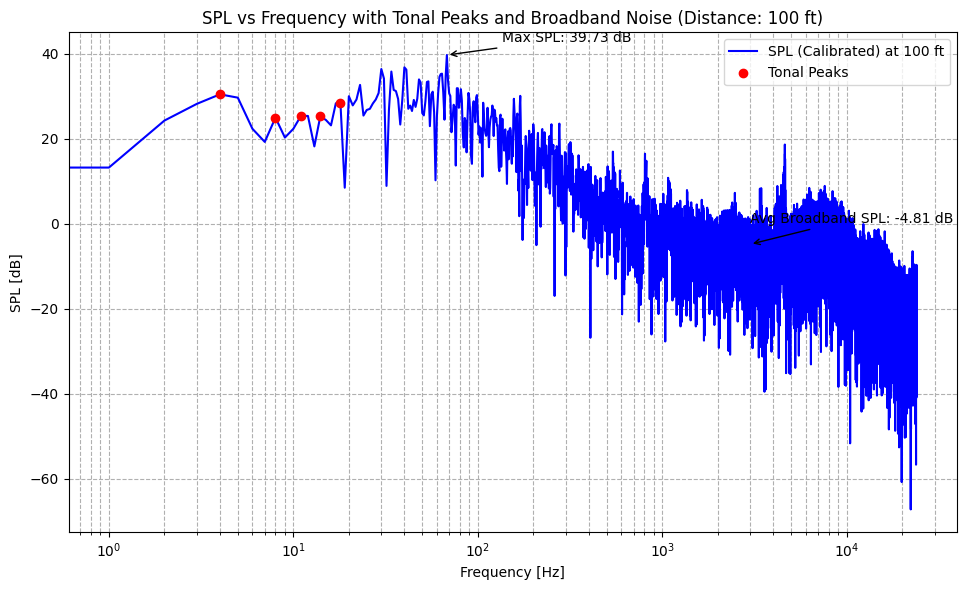

Comparison of Broadband SPL and Max SPL:
Distance: 20 ft - Avg Broadband SPL: 14.15 dB, Max SPL: 47.74 dB
Distance: 40 ft - Avg Broadband SPL: 7.12 dB, Max SPL: 44.77 dB
Distance: 60 ft - Avg Broadband SPL: 0.29 dB, Max SPL: 46.47 dB
Distance: 80 ft - Avg Broadband SPL: -2.11 dB, Max SPL: 47.79 dB
Distance: 100 ft - Avg Broadband SPL: -4.81 dB, Max SPL: 39.73 dB


In [8]:
import numpy as np
import soundfile as sf
import scipy.signal as signal
import matplotlib.pyplot as plt

def read_calibration_file(calibration_path):
    """
    Reads the UMIK-1 calibration file (frequency in Hz and dB correction).
    Returns interpolating function for calibration.
    """
    # Load calibration file data
    data = np.loadtxt(calibration_path, skiprows=1)  # Skip first row with Sens Factor
    freq, correction = data[:, 0], data[:, 1]
    # Interpolation for calibration curve
    calibration_interp = np.interp
    return lambda f: calibration_interp(f, freq, correction)

def compute_spl_db(fft_magnitude, ref=20e-6):
    """
    Convert magnitude to SPL in dB. ref is 20 µPa.
    """
    return 20 * np.log10(fft_magnitude / ref + 1e-20)  # Avoid log(0)

def find_tonal_peaks(freqs, spl, threshold=5, num_peaks=5):
    """
    Finds the first `num_peaks` tonal peaks in the SPL spectrum based on a simple threshold
    compared to the surrounding frequency range.
    """
    peaks, _ = signal.find_peaks(spl, height=threshold)
    return freqs[peaks][:num_peaks], spl[peaks][:num_peaks]  # Return only the first `num_peaks` peaks

def find_broadband_noise_range(freqs, spl, min_freq=1000, max_freq=10000):
    """
    Identifies the broadband noise region by isolating a frequency range
    from min_freq to max_freq.
    """
    freq_mask = (freqs >= min_freq) & (freqs <= max_freq)
    return freqs[freq_mask], spl[freq_mask]

def process_audio_file(wav_path, calibration_path):
    # Load audio file
    data, samplerate = sf.read(wav_path)
    
    # If stereo, convert to mono
    if data.ndim > 1:
        data = np.mean(data, axis=1)

    # Apply a Hann window
    window = np.hanning(len(data))
    data_windowed = data * window

    # FFT
    fft_result = np.fft.rfft(data_windowed)
    freqs = np.fft.rfftfreq(len(data), 1/samplerate)
    fft_magnitude = np.abs(fft_result) / len(data_windowed)

    # Load and interpolate calibration correction
    calib_func = read_calibration_file(calibration_path)
    calib_correction_db = calib_func(freqs)

    # Convert to SPL in dB
    spl = compute_spl_db(fft_magnitude)
    spl_calibrated = spl + calib_correction_db  # Apply calibration

    return freqs, spl_calibrated

def label_and_plot_spl(freqs, spl_calibrated, distance):
    # Find tonal peaks (first 5 peaks)
    peaks_freq, peaks_spl = find_tonal_peaks(freqs, spl_calibrated, threshold=5, num_peaks=5)

    # Find broadband noise region
    broadband_freq, broadband_spl = find_broadband_noise_range(freqs, spl_calibrated, min_freq=1000, max_freq=10000)

    # Calculate the average SPL in the broadband noise range
    avg_broadband_spl = np.mean(broadband_spl)

    # Plot the SPL vs Frequency
    plt.figure(figsize=(10, 6))
    plt.semilogx(freqs, spl_calibrated, label=f'SPL (Calibrated) at {distance} ft', color='blue')

    # Plot only the first 5 tonal peaks
    plt.scatter(peaks_freq, peaks_spl, color='red', label='Tonal Peaks', zorder=5)

    # Calculate the max SPL
    max_spl = np.max(spl_calibrated)

    # Annotate the Max SPL in a better position
    plt.annotate(f'Max SPL: {max_spl:.2f} dB', xy=(freqs[np.argmax(spl_calibrated)], max_spl),
                 xytext=(freqs[np.argmax(spl_calibrated)] * 2, max_spl + 3),
                 arrowprops=dict(facecolor='black', arrowstyle='->'))

    # Label the broadband noise effect
    plt.annotate(f'Avg Broadband SPL: {avg_broadband_spl:.2f} dB', xy=(3000, avg_broadband_spl),
                 xytext=(3000, avg_broadband_spl + 5),
                 arrowprops=dict(facecolor='green', arrowstyle='->'))

    # Labels and Title
    plt.title(f'SPL vs Frequency with Tonal Peaks and Broadband Noise (Distance: {distance} ft)')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('SPL [dB]')
    plt.grid(True, which='both', ls='--')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Return the Avg Broadband SPL and Max SPL for comparison
    return avg_broadband_spl, max_spl

# === Usage ===
calibration_file = r"D:\FYP\Final Project\calibration_file.txt"  # Path to the calibration file
distances = [20, 40, 60, 80, 100]  # Different distances from the mic in feet

# Paths to the audio files for each distance
wav_files = [
    r"D:\FYP\Final Project\SegmentedAudio\DroneA_d20_h10_seg2.wav",  # Path to audio file for 20 ft distance
    r"D:\FYP\Final Project\SegmentedAudio\DroneA_d40_h10_seg4.wav",  # Path to audio file for 40 ft distance
    r"D:\FYP\Final Project\SegmentedAudio\DroneA_d60_h10_seg3.wav",  # Path to audio file for 60 ft distance
    r"D:\FYP\Final Project\SegmentedAudio\DroneA_d80_h10_seg7.wav",  # Path to audio file for 80 ft distance
    r"D:\FYP\Final Project\SegmentedAudio\DroneA_d100_h101_seg5.wav"  # Path to audio file for 100 ft distance
]

# Collect Avg Broadband SPL and Max SPL for comparison
comparison_data = []

# Process each audio file and plot a separate graph for each distance
for wav_file, distance in zip(wav_files, distances):
    freqs, spl_calibrated = process_audio_file(wav_file, calibration_file)
    avg_broadband_spl, max_spl = label_and_plot_spl(freqs, spl_calibrated, distance)
    comparison_data.append((distance, avg_broadband_spl, max_spl))

# Print the comparison data for each plot
print("Comparison of Broadband SPL and Max SPL:")
for distance, avg_broadband_spl, max_spl in comparison_data:
    print(f"Distance: {distance} ft - Avg Broadband SPL: {avg_broadband_spl:.2f} dB, Max SPL: {max_spl:.2f} dB")


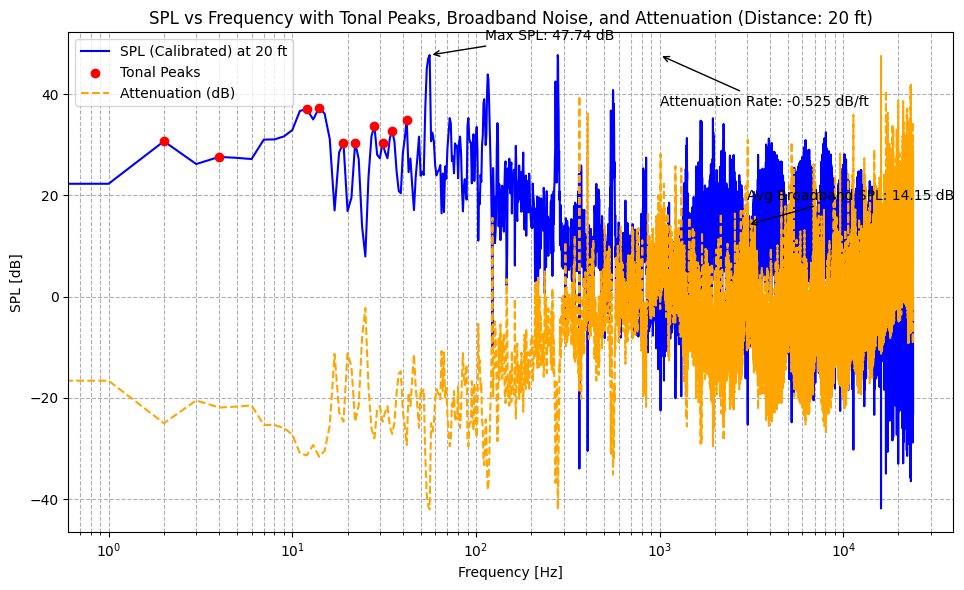

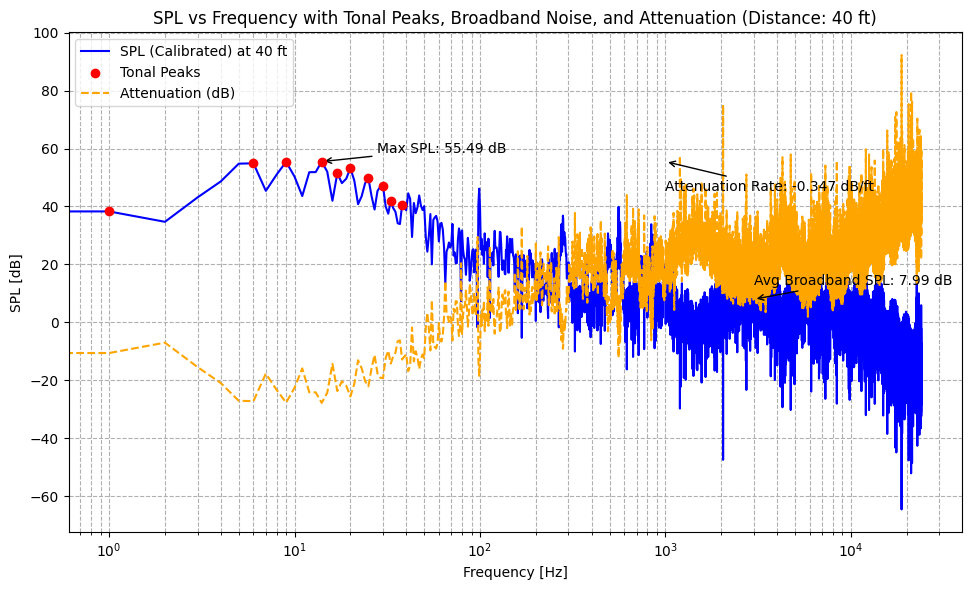

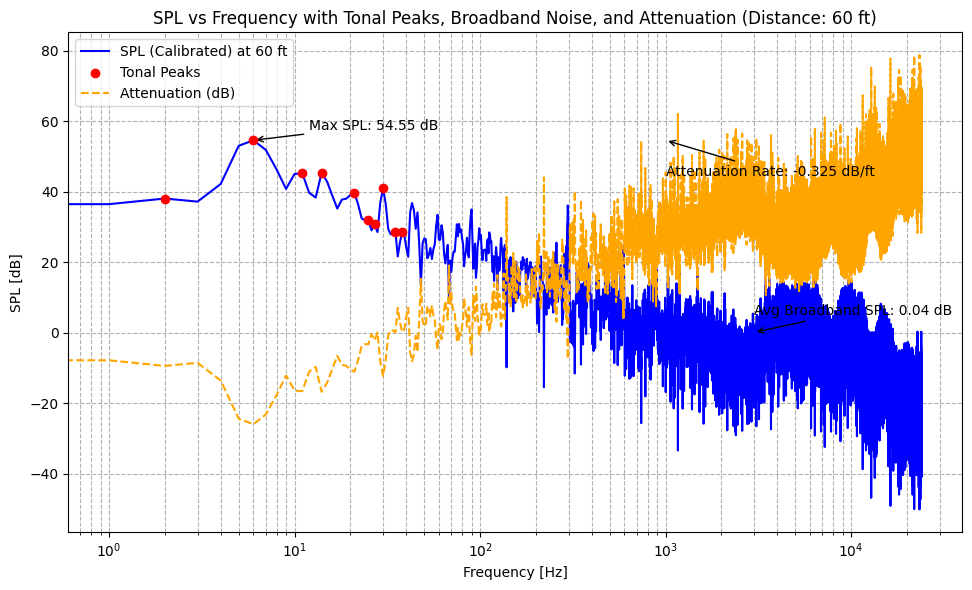

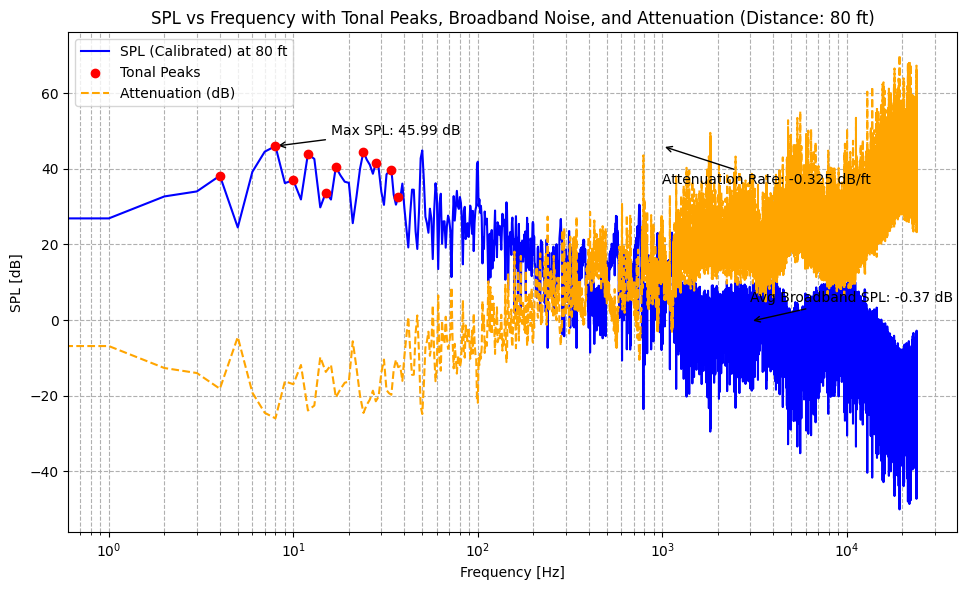

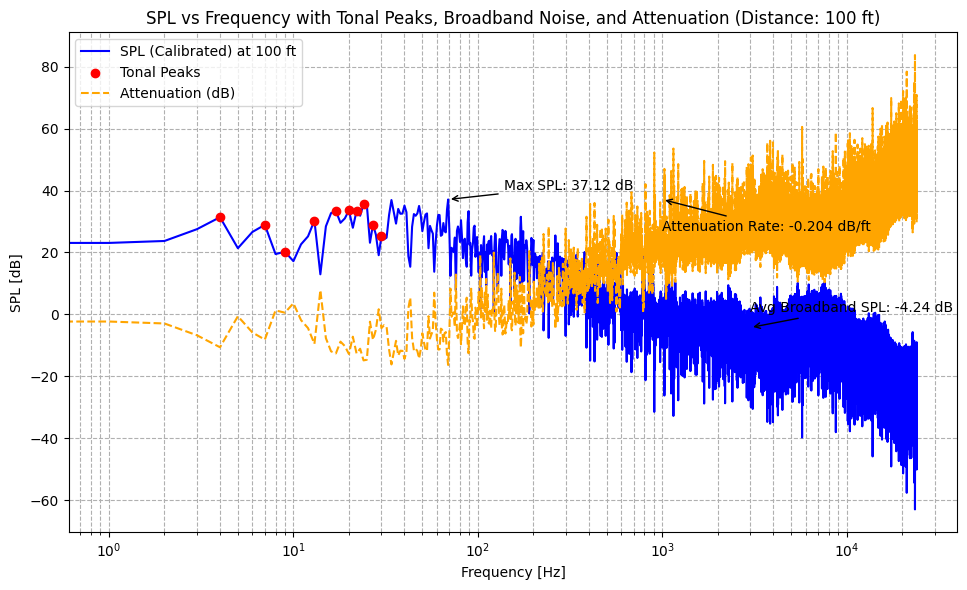

Comparison of Broadband SPL, Max SPL, and Attenuation Rate:
Distance: 20 ft - Avg Broadband SPL: 14.15 dB, Max SPL: 47.74 dB, Attenuation Rate: -0.525 dB/ft
Distance: 40 ft - Avg Broadband SPL: 7.99 dB, Max SPL: 55.49 dB, Attenuation Rate: -0.347 dB/ft
Distance: 60 ft - Avg Broadband SPL: 0.04 dB, Max SPL: 54.55 dB, Attenuation Rate: -0.325 dB/ft
Distance: 80 ft - Avg Broadband SPL: -0.37 dB, Max SPL: 45.99 dB, Attenuation Rate: -0.325 dB/ft
Distance: 100 ft - Avg Broadband SPL: -4.24 dB, Max SPL: 37.12 dB, Attenuation Rate: -0.204 dB/ft


In [15]:
def read_calibration_file(calibration_path):
    """
    Reads the UMIK-1 calibration file (frequency in Hz and dB correction).
    Returns interpolating function for calibration.
    """
    # Load calibration file data
    data = np.loadtxt(calibration_path, skiprows=1)  # Skip first row with Sens Factor
    freq, correction = data[:, 0], data[:, 1]
    # Interpolation for calibration curve
    calibration_interp = np.interp
    return lambda f: calibration_interp(f, freq, correction)

def compute_spl_db(fft_magnitude, ref=20e-6):
    """
    Convert magnitude to SPL in dB. ref is 20 µPa.
    """
    return 20 * np.log10(fft_magnitude / ref + 1e-20)  # Avoid log(0)

def find_tonal_peaks(freqs, spl, threshold=5, num_peaks=10):
    """
    Finds the first `num_peaks` tonal peaks in the SPL spectrum based on a simple threshold
    compared to the surrounding frequency range.
    """
    peaks, _ = signal.find_peaks(spl, height=threshold)
    return freqs[peaks][:num_peaks], spl[peaks][:num_peaks]  # Return only the first `num_peaks` peaks

def find_broadband_noise_range(freqs, spl, min_freq=1000, max_freq=10000):
    """
    Identifies the broadband noise region by isolating a frequency range
    from min_freq to max_freq.
    """
    freq_mask = (freqs >= min_freq) & (freqs <= max_freq)
    return freqs[freq_mask], spl[freq_mask]

def process_audio_file(wav_path, calibration_path):
    # Load audio file
    data, samplerate = sf.read(wav_path)
    
    # If stereo, convert to mono
    if data.ndim > 1:
        data = np.mean(data, axis=1)

    # Apply a Hann window
    window = np.hanning(len(data))
    data_windowed = data * window

    # FFT
    fft_result = np.fft.rfft(data_windowed)
    freqs = np.fft.rfftfreq(len(data), 1/samplerate)
    fft_magnitude = np.abs(fft_result) / len(data_windowed)

    # Load and interpolate calibration correction
    calib_func = read_calibration_file(calibration_path)
    calib_correction_db = calib_func(freqs)

    # Convert to SPL in dB
    spl = compute_spl_db(fft_magnitude)
    spl_calibrated = spl + calib_correction_db  # Apply calibration

    return freqs, spl_calibrated

def label_and_plot_spl(freqs, spl_calibrated, distance, reference_spl):
    # Find tonal peaks (first 10 peaks)
    peaks_freq, peaks_spl = find_tonal_peaks(freqs, spl_calibrated, threshold=5, num_peaks=10)

    # Find broadband noise region
    broadband_freq, broadband_spl = find_broadband_noise_range(freqs, spl_calibrated, min_freq=1000, max_freq=10000)

    # Calculate the average SPL in the broadband noise range
    avg_broadband_spl = np.mean(broadband_spl)

    # Calculate the SPL attenuation (difference from reference SPL)
    attenuation = reference_spl - spl_calibrated

    # Calculate the attenuation rate (dB per unit distance)
    distance_ref = 20  # Reference distance (e.g., 20 ft)
    max_distance = 100  # Max distance to consider
    attenuation_rate = (reference_spl - max(spl_calibrated)) / (max_distance - distance_ref)

    # Plot the SPL vs Frequency
    plt.figure(figsize=(10, 6))
    plt.semilogx(freqs, spl_calibrated, label=f'SPL (Calibrated) at {distance} ft', color='blue')

    # Plot only the first 10 tonal peaks
    plt.scatter(peaks_freq, peaks_spl, color='red', label='Tonal Peaks', zorder=5)

    # Calculate the max SPL
    max_spl = np.max(spl_calibrated)

    # Annotate the Max SPL in a better position
    plt.annotate(f'Max SPL: {max_spl:.2f} dB', xy=(freqs[np.argmax(spl_calibrated)], max_spl),
                 xytext=(freqs[np.argmax(spl_calibrated)] * 2, max_spl + 3),
                 arrowprops=dict(facecolor='black', arrowstyle='->'))

    # Label the broadband noise effect
    plt.annotate(f'Avg Broadband SPL: {avg_broadband_spl:.2f} dB', xy=(3000, avg_broadband_spl),
                 xytext=(3000, avg_broadband_spl + 5),
                 arrowprops=dict(facecolor='green', arrowstyle='->'))

    # Plot the attenuation as a line
    plt.plot(freqs, attenuation, label='Attenuation (dB)', color='orange', linestyle='--')

    # Annotate the attenuation rate
    plt.annotate(f'Attenuation Rate: {attenuation_rate:.3f} dB/ft', xy=(1000, max_spl),
                 xytext=(1000, max_spl - 10),
                 arrowprops=dict(facecolor='orange', arrowstyle='->'))

    # Labels and Title
    plt.title(f'SPL vs Frequency with Tonal Peaks, Broadband Noise, and Attenuation (Distance: {distance} ft)')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('SPL [dB]')
    plt.grid(True, which='both', ls='--')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Return the Avg Broadband SPL, Max SPL, and attenuation for comparison
    return avg_broadband_spl, max_spl, attenuation_rate

# === Usage ===
calibration_file = r"D:\FYP\Final Project\calibration_file.txt"  # Path to the calibration file
distances = [20, 40, 60, 80, 100]  # Different distances from the mic in feet

# Paths to the audio files for each distance
wav_files = [
    r"D:\FYP\Final Project\SegmentedAudio\DroneA_d20_h10_seg2.wav",  # Path to audio file for 20 ft distance
    r"D:\FYP\Final Project\SegmentedAudio\DroneA_d40_h10_seg10.wav",  # Path to audio file for 40 ft distance
    r"D:\FYP\Final Project\SegmentedAudio\DroneA_d60_h10_seg1.wav",  # Path to audio file for 60 ft distance
    r"D:\FYP\Final Project\SegmentedAudio\DroneA_d80_h10_seg1.wav",  # Path to audio file for 80 ft distance
    r"D:\FYP\Final Project\SegmentedAudio\DroneA_d100_h101_seg9.wav"  # Path to audio file for 100 ft distance
]

# Collect Avg Broadband SPL, Max SPL, and attenuation for comparison
comparison_data = []

# Process each audio file and plot a separate graph for each distance
for wav_file, distance in zip(wav_files, distances):
    freqs, spl_calibrated = process_audio_file(wav_file, calibration_file)
    reference_spl = spl_calibrated[0]  # Assuming reference SPL at the lowest frequency
    avg_broadband_spl, max_spl, attenuation_rate = label_and_plot_spl(freqs, spl_calibrated, distance, reference_spl)
    comparison_data.append((distance, avg_broadband_spl, max_spl, attenuation_rate))

# Print the comparison data for each plot
print("Comparison of Broadband SPL, Max SPL, and Attenuation Rate:")
for distance, avg_broadband_spl, max_spl, attenuation_rate in comparison_data:
    print(f"Distance: {distance} ft - Avg Broadband SPL: {avg_broadband_spl:.2f} dB, Max SPL: {max_spl:.2f} dB, Attenuation Rate: {attenuation_rate:.3f} dB/ft")


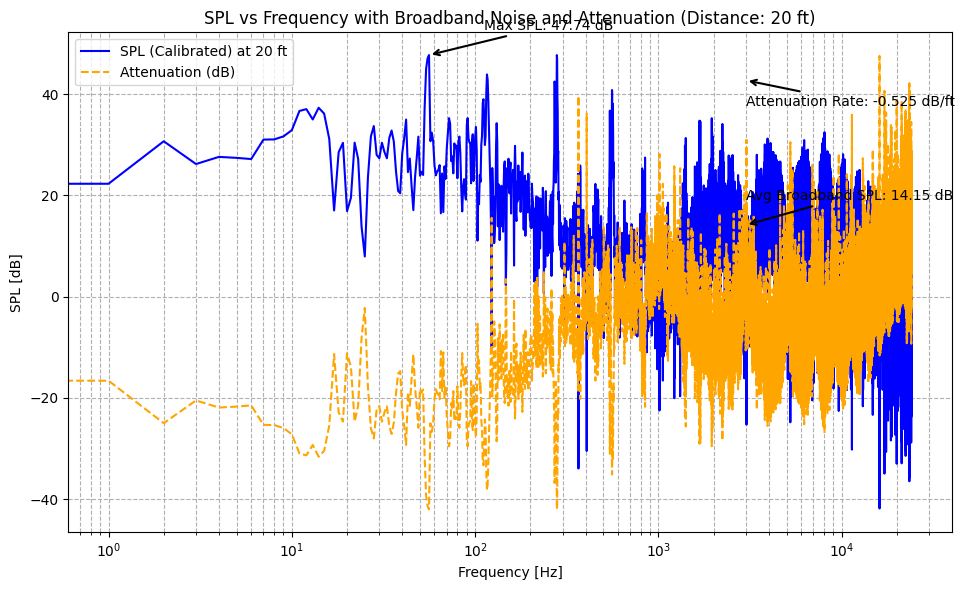

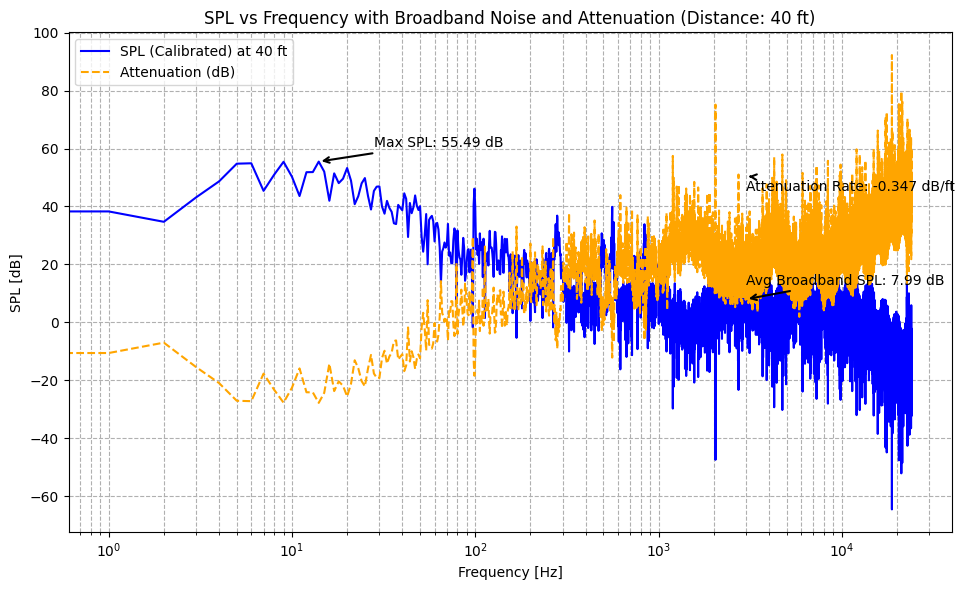

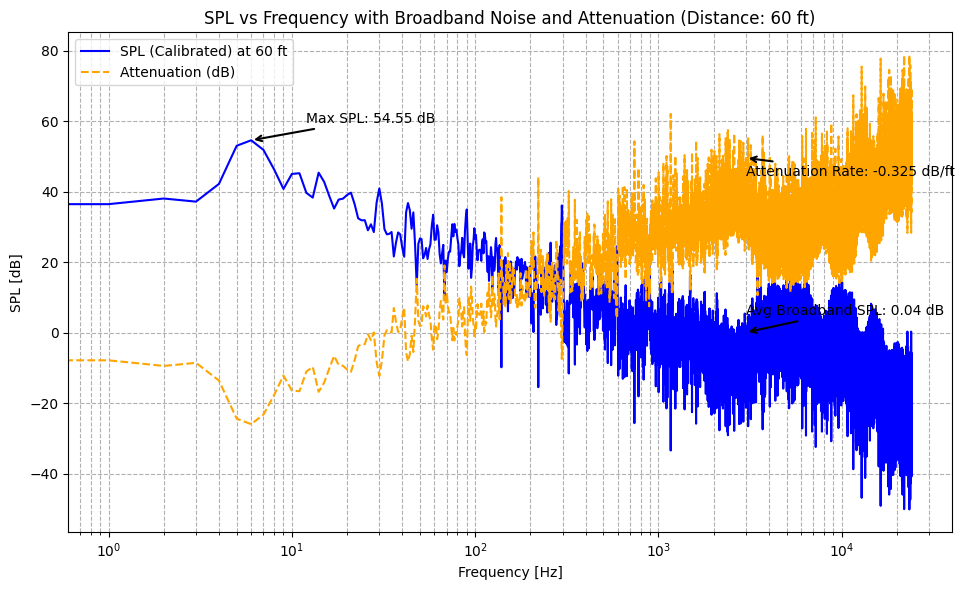

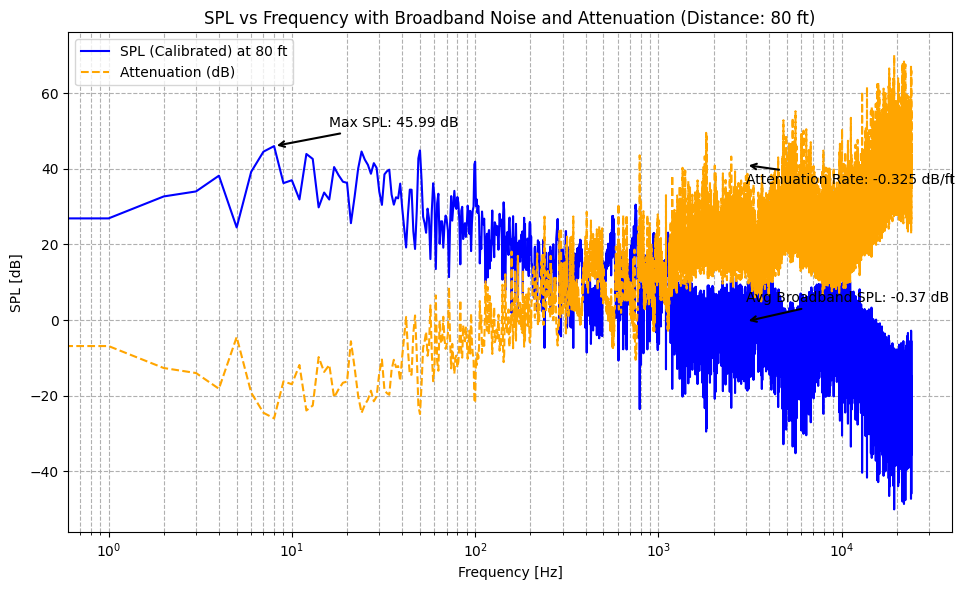

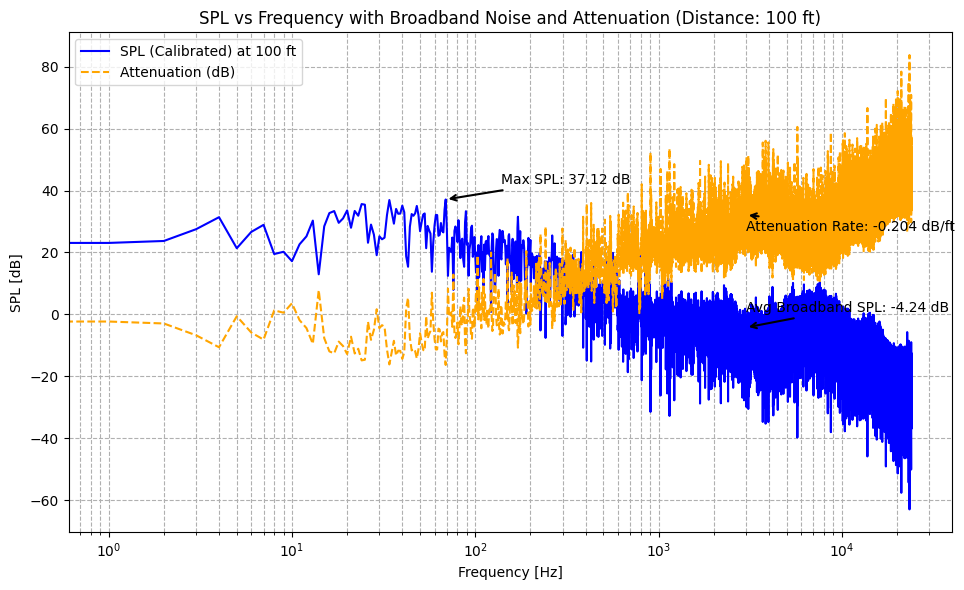

Comparison of Broadband SPL, Max SPL, and Attenuation Rate:
Distance: 20 ft - Avg Broadband SPL: 14.15 dB, Max SPL: 47.74 dB, Attenuation Rate: -0.525 dB/ft
Distance: 40 ft - Avg Broadband SPL: 7.99 dB, Max SPL: 55.49 dB, Attenuation Rate: -0.347 dB/ft
Distance: 60 ft - Avg Broadband SPL: 0.04 dB, Max SPL: 54.55 dB, Attenuation Rate: -0.325 dB/ft
Distance: 80 ft - Avg Broadband SPL: -0.37 dB, Max SPL: 45.99 dB, Attenuation Rate: -0.325 dB/ft
Distance: 100 ft - Avg Broadband SPL: -4.24 dB, Max SPL: 37.12 dB, Attenuation Rate: -0.204 dB/ft


In [4]:
def read_calibration_file(calibration_path):
    """
    Reads the UMIK-1 calibration file (frequency in Hz and dB correction).
    Returns interpolating function for calibration.
    """
    # Load calibration file data
    data = np.loadtxt(calibration_path, skiprows=1)  # Skip first row with Sens Factor
    freq, correction = data[:, 0], data[:, 1]
    # Interpolation for calibration curve
    calibration_interp = np.interp
    return lambda f: calibration_interp(f, freq, correction)

def compute_spl_db(fft_magnitude, ref=20e-6):
    """
    Convert magnitude to SPL in dB. ref is 20 µPa.
    """
    return 20 * np.log10(fft_magnitude / ref + 1e-20)  # Avoid log(0)

def find_tonal_peaks(freqs, spl, threshold=5, num_peaks=10):
    """
    Finds the first `num_peaks` tonal peaks in the SPL spectrum based on a simple threshold
    compared to the surrounding frequency range.
    """
    peaks, _ = signal.find_peaks(spl, height=threshold)
    return freqs[peaks][:num_peaks], spl[peaks][:num_peaks]  # Return only the first `num_peaks` peaks

def find_broadband_noise_range(freqs, spl, min_freq=1000, max_freq=10000):
    """
    Identifies the broadband noise region by isolating a frequency range
    from min_freq to max_freq.
    """
    freq_mask = (freqs >= min_freq) & (freqs <= max_freq)
    return freqs[freq_mask], spl[freq_mask]

def process_audio_file(wav_path, calibration_path):
    # Load audio file
    data, samplerate = sf.read(wav_path)
    
    # If stereo, convert to mono
    if data.ndim > 1:
        data = np.mean(data, axis=1)

    # Apply a Hann window
    window = np.hanning(len(data))
    data_windowed = data * window

    # FFT
    fft_result = np.fft.rfft(data_windowed)
    freqs = np.fft.rfftfreq(len(data), 1/samplerate)
    fft_magnitude = np.abs(fft_result) / len(data_windowed)

    # Load and interpolate calibration correction
    calib_func = read_calibration_file(calibration_path)
    calib_correction_db = calib_func(freqs)

    # Convert to SPL in dB
    spl = compute_spl_db(fft_magnitude)
    spl_calibrated = spl + calib_correction_db  # Apply calibration

    return freqs, spl_calibrated

def label_and_plot_spl(freqs, spl_calibrated, distance, reference_spl):
    # Find broadband noise region
    broadband_freq, broadband_spl = find_broadband_noise_range(freqs, spl_calibrated, min_freq=1000, max_freq=10000)

    # Calculate the average SPL in the broadband noise range
    avg_broadband_spl = np.mean(broadband_spl)

    # Calculate the SPL attenuation (difference from reference SPL)
    attenuation = reference_spl - spl_calibrated

    # Calculate the attenuation rate (dB per unit distance)
    distance_ref = 20  # Reference distance (e.g., 20 ft)
    max_distance = 100  # Max distance to consider
    attenuation_rate = (reference_spl - np.max(spl_calibrated)) / (max_distance - distance_ref)

    # Plot the SPL vs Frequency
    plt.figure(figsize=(10, 6))
    plt.semilogx(freqs, spl_calibrated, label=f'SPL (Calibrated) at {distance} ft', color='blue')

    # Calculate the max SPL
    max_spl = np.max(spl_calibrated)

    # Annotate the Max SPL
    plt.annotate(f'Max SPL: {max_spl:.2f} dB', xy=(freqs[np.argmax(spl_calibrated)], max_spl),
                 xytext=(freqs[np.argmax(spl_calibrated)] * 2, max_spl + 5),
                 arrowprops=dict(facecolor='black', arrowstyle='->', lw=1.5))

    # Annotate average broadband SPL
    plt.annotate(f'Avg Broadband SPL: {avg_broadband_spl:.2f} dB', xy=(3000, avg_broadband_spl),
                 xytext=(3000, avg_broadband_spl + 5),
                 arrowprops=dict(facecolor='green', arrowstyle='->', lw=1.5))

    # Plot the attenuation curve
    plt.plot(freqs, attenuation, label='Attenuation (dB)', color='orange', linestyle='--')

    # Annotate the attenuation rate
    plt.annotate(f'Attenuation Rate: {attenuation_rate:.3f} dB/ft', xy=(3000, max_spl - 5),
                 xytext=(3000, max_spl - 10),
                 arrowprops=dict(facecolor='orange', arrowstyle='->', lw=1.5))

    # Labels and Title
    plt.title(f'SPL vs Frequency with Broadband Noise and Attenuation (Distance: {distance} ft)')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('SPL [dB]')
    plt.grid(True, which='both', ls='--')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return avg_broadband_spl, max_spl, attenuation_rate


    # Return the Avg Broadband SPL, Max SPL, and attenuation for comparison
    return avg_broadband_spl, max_spl, attenuation_rate

# === Usage ===
calibration_file = r"D:\FYP\Final Project\calibration_file.txt"  # Path to the calibration file
distances = [20, 40, 60, 80, 100]  # Different distances from the mic in feet

# Paths to the audio files for each distance
wav_files = [
    r"D:\FYP\Final Project\SegmentedAudio\DroneA_d20_h10_seg2.wav",  # Path to audio file for 20 ft distance
    r"D:\FYP\Final Project\SegmentedAudio\DroneA_d40_h10_seg10.wav",  # Path to audio file for 40 ft distance
    r"D:\FYP\Final Project\SegmentedAudio\DroneA_d60_h10_seg1.wav",  # Path to audio file for 60 ft distance
    r"D:\FYP\Final Project\SegmentedAudio\DroneA_d80_h10_seg1.wav",  # Path to audio file for 80 ft distance
    r"D:\FYP\Final Project\SegmentedAudio\DroneA_d100_h101_seg9.wav"  # Path to audio file for 100 ft distance
]

# Collect Avg Broadband SPL, Max SPL, and attenuation for comparison
comparison_data = []

# Process each audio file and plot a separate graph for each distance
for wav_file, distance in zip(wav_files, distances):
    freqs, spl_calibrated = process_audio_file(wav_file, calibration_file)
    reference_spl = spl_calibrated[0]  # Assuming reference SPL at the lowest frequency
    avg_broadband_spl, max_spl, attenuation_rate = label_and_plot_spl(freqs, spl_calibrated, distance, reference_spl)
    comparison_data.append((distance, avg_broadband_spl, max_spl, attenuation_rate))

# Print the comparison data for each plot
print("Comparison of Broadband SPL, Max SPL, and Attenuation Rate:")
for distance, avg_broadband_spl, max_spl, attenuation_rate in comparison_data:
    print(f"Distance: {distance} ft - Avg Broadband SPL: {avg_broadband_spl:.2f} dB, Max SPL: {max_spl:.2f} dB, Attenuation Rate: {attenuation_rate:.3f} dB/ft")


TypeError: unsupported format string passed to numpy.ndarray.__format__

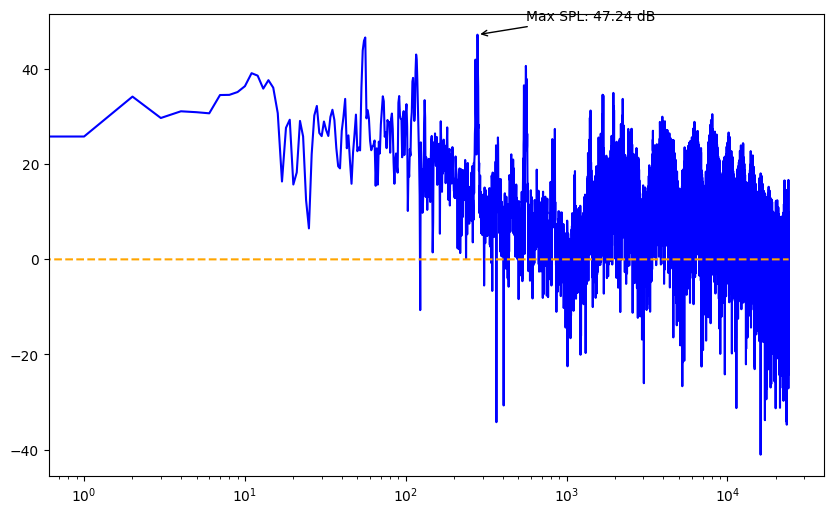

In [2]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

def compute_spl_db(fft_magnitude, ref=20e-6):
    """
    Convert magnitude to SPL in dB. ref is 20 µPa.
    """
    return 20 * np.log10(fft_magnitude / ref + 1e-20)

def process_audio_file(wav_path):
    # Load audio file
    data, samplerate = sf.read(wav_path)

    # Convert to mono if stereo
    if data.ndim > 1:
        data = np.mean(data, axis=1)

    # Apply Hann window
    window = np.hanning(len(data))
    data_windowed = data * window

    # Perform FFT
    fft_result = np.fft.rfft(data_windowed)
    freqs = np.fft.rfftfreq(len(data), 1 / samplerate)
    fft_magnitude = np.abs(fft_result) / len(data_windowed)

    # Convert to uncalibrated SPL
    spl = compute_spl_db(fft_magnitude)
    return freqs, spl

def plot_spl_with_attenuation(freqs, spl, distance, reference_spl, reference_distance=20, max_distance=100):
    # Calculate attenuation
    attenuation = reference_spl - spl
    attenuation_rate = (reference_spl - np.max(spl)) / (max_distance - reference_distance)

    # Plot SPL
    plt.figure(figsize=(10, 6))
    plt.semilogx(freqs, spl, label=f'SPL at {distance} ft', color='blue')
    plt.plot(freqs, attenuation, label='Attenuation (dB)', color='orange', linestyle='--')

    # Annotate max SPL
    max_idx = np.argmax(spl)
    max_spl = spl[max_idx]
    plt.annotate(f'Max SPL: {max_spl:.2f} dB',
                 xy=(freqs[max_idx], max_spl),
                 xytext=(freqs[max_idx] * 2, max_spl + 3),
                 arrowprops=dict(facecolor='black', arrowstyle='->'))

    # Annotate attenuation rate
    plt.annotate(f'Attenuation Rate: {attenuation_rate:.3f} dB/ft',
                 xy=(1000, max_spl - 5),
                 xytext=(1000, max_spl - 10),
                 arrowprops=dict(facecolor='orange', arrowstyle='->'))

    # Labels
    plt.title(f'SPL vs Frequency (Distance: {distance} ft)')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('SPL [dB]')
    plt.grid(True, which='both', ls='--')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return np.mean(spl), max_spl, attenuation_rate

# === Usage ===
distances = [20, 40, 60, 80, 100]
# Paths to the audio files for each distance
wav_files = [
    r"D:\FYP\Final Project\SegmentedAudio\DroneA_d20_h10_seg2.wav",  # Path to audio file for 20 ft distance
    r"D:\FYP\Final Project\SegmentedAudio\DroneA_d40_h10_seg10.wav",  # Path to audio file for 40 ft distance
    r"D:\FYP\Final Project\SegmentedAudio\DroneA_d60_h10_seg1.wav",  # Path to audio file for 60 ft distance
    r"D:\FYP\Final Project\SegmentedAudio\DroneA_d80_h10_seg1.wav",  # Path to audio file for 80 ft distance
    r"D:\FYP\Final Project\SegmentedAudio\DroneA_d100_h101_seg9.wav"  # Path to audio file for 100 ft distance
]

# Run for each file
reference_spl = None
for wav_file, distance in zip(wav_files, distances):
    freqs, spl = process_audio_file(wav_file)
    
    # Set reference SPL from the first file
    if distance == 20:
        reference_spl = spl.copy()

    avg_spl, max_spl, attenuation_rate = plot_spl_with_attenuation(freqs, spl, distance, reference_spl)


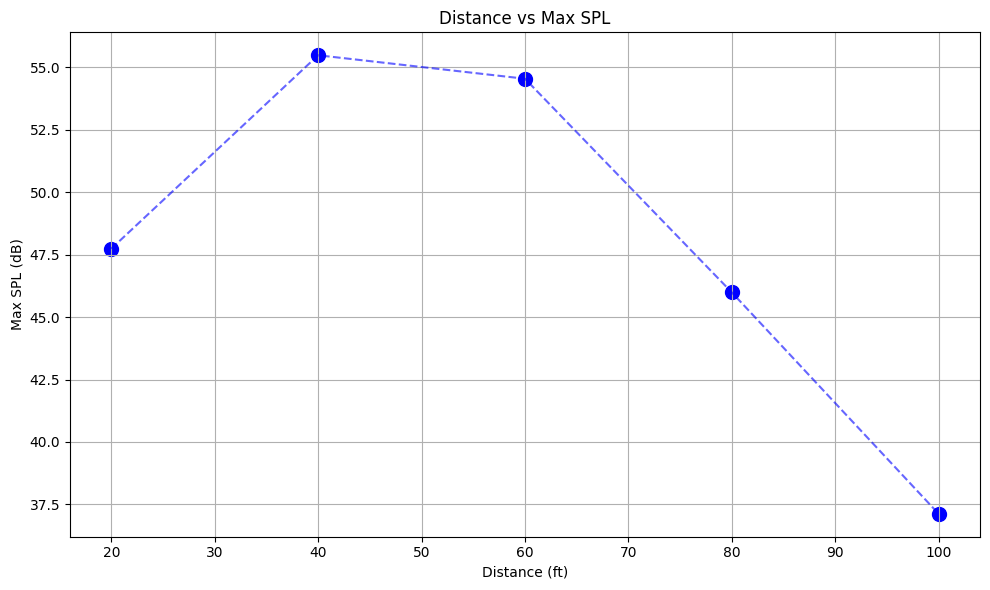

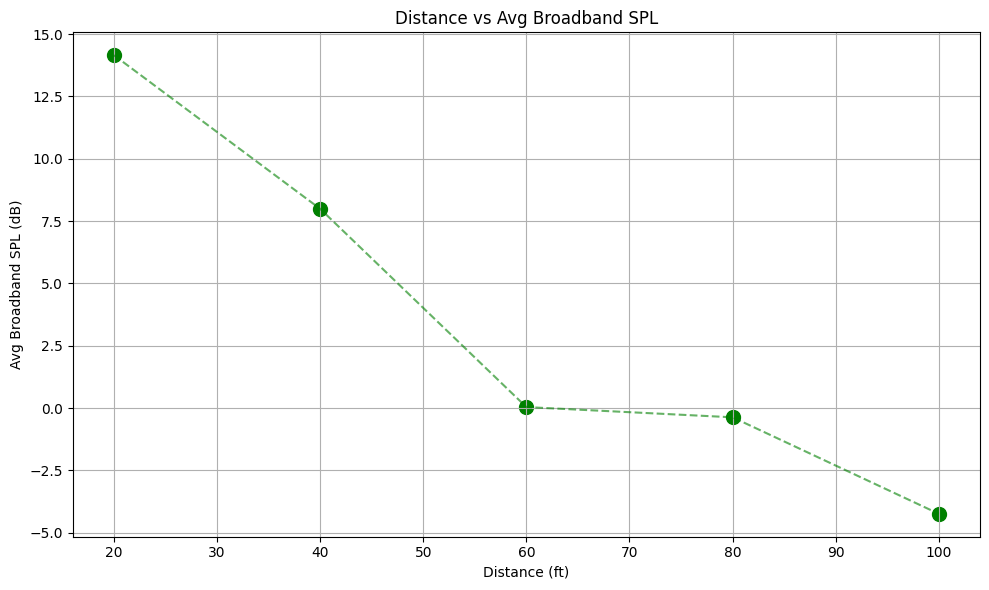

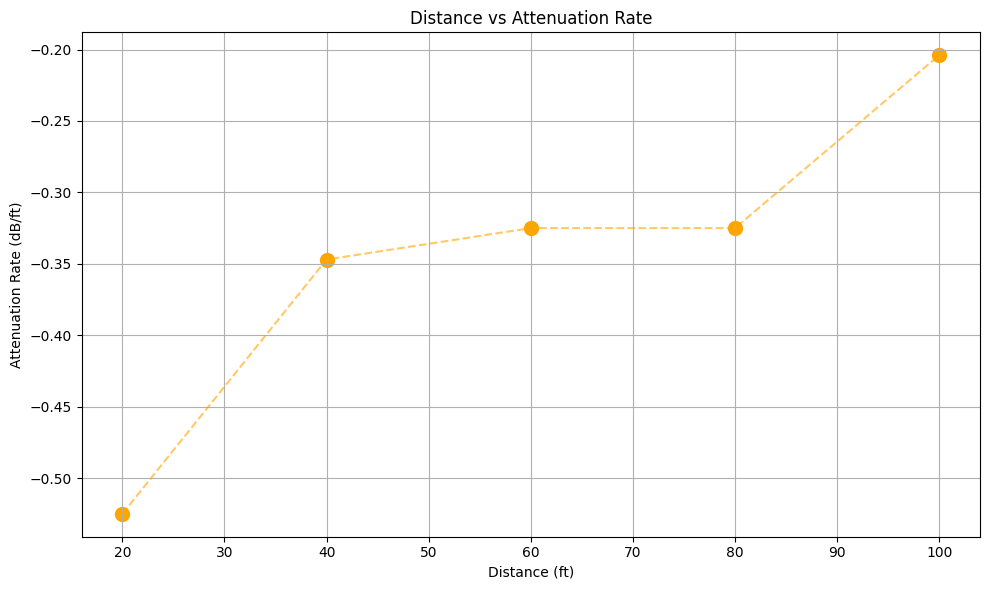

In [27]:
import matplotlib.pyplot as plt

# Comparison data from your output
comparison_data = [
    (20, 14.15, 47.74, -0.525),  # (Distance, Avg Broadband SPL, Max SPL, Attenuation Rate)
    (40, 7.99, 55.49, -0.347),
    (60, 0.04, 54.55, -0.325),
    (80, -0.37, 45.99, -0.325),
    (100, -4.24, 37.12, -0.204)
]

# Extracting values for plotting
distances = [item[0] for item in comparison_data]
avg_broadband_spl = [item[1] for item in comparison_data]
max_spl = [item[2] for item in comparison_data]
attenuation_rate = [item[3] for item in comparison_data]

# Plot Distance vs Max SPL
plt.figure(figsize=(10, 6))
plt.scatter(distances, max_spl, color='blue', s=100)
plt.plot(distances, max_spl, color='blue', linestyle='--', alpha=0.6)  # Connecting the points with a dashed line
plt.xlabel('Distance (ft)')
plt.ylabel('Max SPL (dB)')
plt.title('Distance vs Max SPL')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Distance vs Avg Broadband SPL
plt.figure(figsize=(10, 6))
plt.scatter(distances, avg_broadband_spl, color='green', s=100)
plt.plot(distances, avg_broadband_spl, color='green', linestyle='--', alpha=0.6)  # Connecting the points with a dashed line
plt.xlabel('Distance (ft)')
plt.ylabel('Avg Broadband SPL (dB)')
plt.title('Distance vs Avg Broadband SPL')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Distance vs Attenuation Rate
plt.figure(figsize=(10, 6))
plt.scatter(distances, attenuation_rate, color='orange', s=100)
plt.plot(distances, attenuation_rate, color='orange', linestyle='--', alpha=0.6)  # Connecting the points with a dashed line
plt.xlabel('Distance (ft)')
plt.ylabel('Attenuation Rate (dB/ft)')
plt.title('Distance vs Attenuation Rate')
plt.grid(True)
plt.tight_layout()
plt.show()


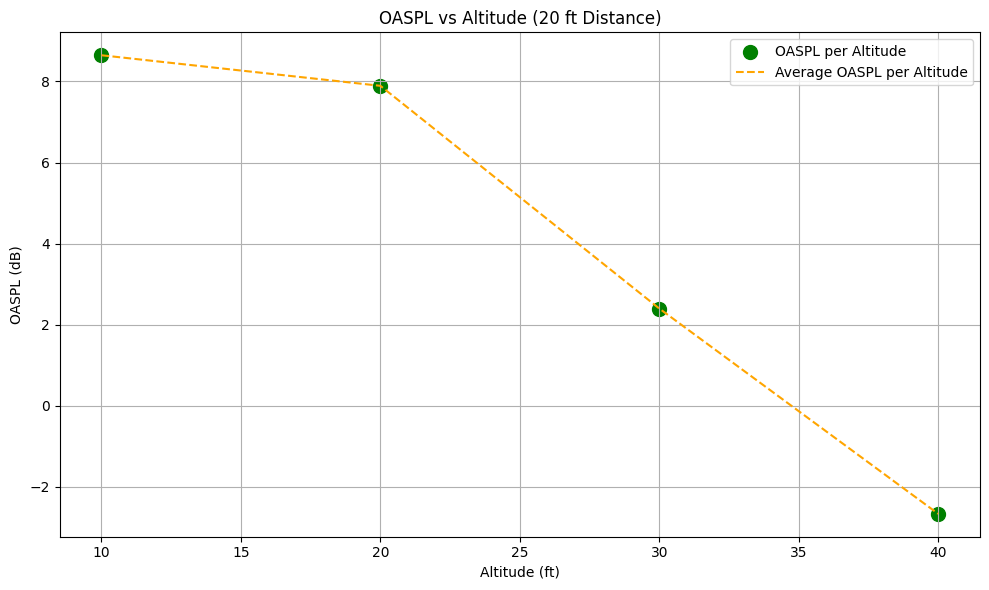

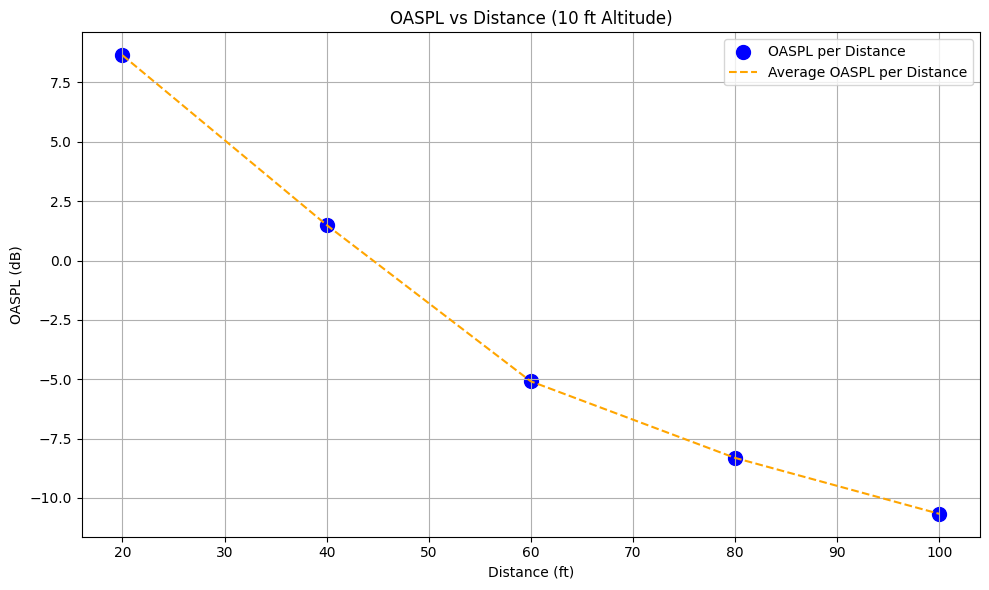

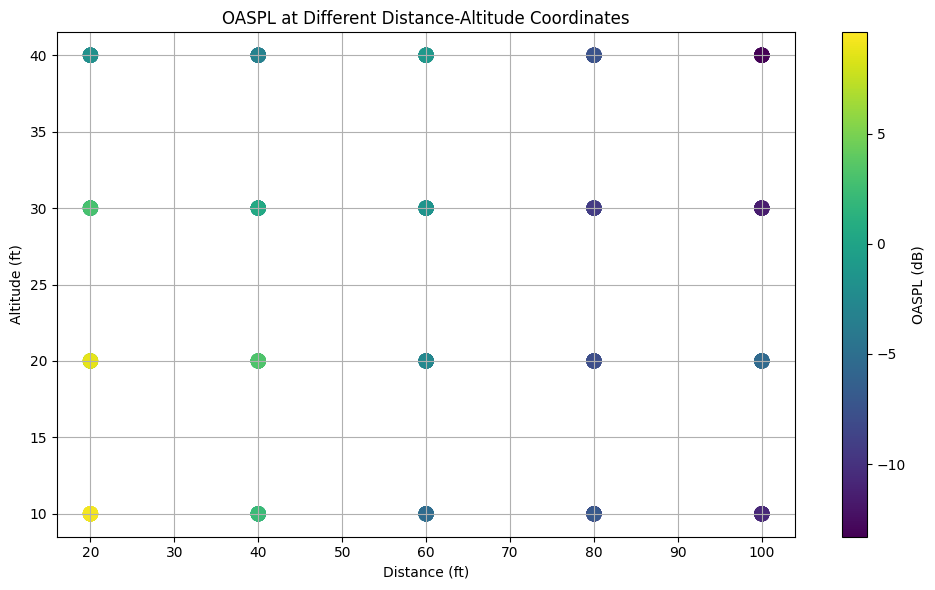

In [24]:
import os
import numpy as np
import soundfile as sf
import scipy.signal as signal
import matplotlib.pyplot as plt
from collections import defaultdict

def read_calibration_file(calibration_path):
    """
    Reads the UMIK-1 calibration file (frequency in Hz and dB correction).
    Returns interpolating function for calibration.
    """
    # Load calibration file data
    data = np.loadtxt(calibration_path, skiprows=1)  # Skip first row with Sens Factor
    freq, correction = data[:, 0], data[:, 1]
    # Interpolation for calibration curve
    calibration_interp = np.interp
    return lambda f: calibration_interp(f, freq, correction)

def compute_spl_db(fft_magnitude, ref=20e-6):
    """
    Convert magnitude to SPL in dB. ref is 20 µPa.
    """
    return 20 * np.log10(fft_magnitude / ref + 1e-20)  # Avoid log(0)

def process_audio_file(wav_path, calibration_path):
    # Load audio file
    data, samplerate = sf.read(wav_path)
    
    # If stereo, convert to mono
    if data.ndim > 1:
        data = np.mean(data, axis=1)

    # Apply a Hann window
    window = np.hanning(len(data))
    data_windowed = data * window

    # FFT
    fft_result = np.fft.rfft(data_windowed)
    freqs = np.fft.rfftfreq(len(data), 1/samplerate)
    fft_magnitude = np.abs(fft_result) / len(data_windowed)

    # Load and interpolate calibration correction
    calib_func = read_calibration_file(calibration_path)
    calib_correction_db = calib_func(freqs)

    # Convert to SPL in dB
    spl = compute_spl_db(fft_magnitude)
    spl_calibrated = spl + calib_correction_db  # Apply calibration

    return freqs, spl_calibrated

def calculate_oaspl(spl_calibrated):
    """
    Calculates the Overall Sound Pressure Level (OASPL) from the SPL data.
    This is an average SPL across the frequency spectrum.
    """
    # OASPL is essentially the average SPL across all frequencies
    oaspl = np.mean(spl_calibrated)
    return oaspl

def plot_oaspl(oaspl_values, coordinates):
    """
    Plot the OASPL values on a 2D scatter plot with distance and altitude as axes.
    """
    distances, altitudes = zip(*coordinates)
    plt.figure(figsize=(10, 6))
    plt.scatter(distances, altitudes, c=oaspl_values, cmap='viridis', s=100)
    plt.colorbar(label="OASPL (dB)")
    plt.xlabel('Distance (ft)')
    plt.ylabel('Altitude (ft)')
    plt.title('OASPL at Different Distance-Altitude Coordinates')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_oaspl_vs_distance(oaspl_values, distances):
    """
    Plot OASPL vs Distance for 10 ft altitude (scatter plot without lines).
    """
    # Calculate average OASPL for each distance
    distance_oaspl = defaultdict(list)
    for oaspl, distance in zip(oaspl_values, distances):
        distance_oaspl[distance].append(oaspl)
    
    avg_oaspl_distances = [np.mean(distance_oaspl[distance]) for distance in sorted(distance_oaspl)]
    plt.figure(figsize=(10, 6))
    plt.scatter(sorted(distance_oaspl), avg_oaspl_distances, color='blue', s=100, label='OASPL per Distance')
    
    # Plot the average line
    plt.plot(sorted(distance_oaspl), avg_oaspl_distances, color='orange', linestyle='--', label='Average OASPL per Distance')
    
    plt.xlabel('Distance (ft)')
    plt.ylabel('OASPL (dB)')
    plt.title('OASPL vs Distance (10 ft Altitude)')
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

def plot_oaspl_vs_altitude(oaspl_values, altitudes):
    """
    Plot OASPL vs Altitude for 20 ft distance (scatter plot without lines).
    """
    # Calculate average OASPL for each altitude
    altitude_oaspl = defaultdict(list)
    for oaspl, altitude in zip(oaspl_values, altitudes):
        altitude_oaspl[altitude].append(oaspl)
    
    avg_oaspl_altitudes = [np.mean(altitude_oaspl[altitude]) for altitude in sorted(altitude_oaspl)]
    plt.figure(figsize=(10, 6))
    plt.scatter(sorted(altitude_oaspl), avg_oaspl_altitudes, color='green', s=100, label='OASPL per Altitude')

    # Plot the average line
    plt.plot(sorted(altitude_oaspl), avg_oaspl_altitudes, color='orange', linestyle='--', label='Average OASPL per Altitude')

    plt.xlabel('Altitude (ft)')
    plt.ylabel('OASPL (dB)')
    plt.title('OASPL vs Altitude (20 ft Distance)')
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

# === Usage ===
calibration_file = r"D:\FYP\Final Project\calibration_file.txt"  # Path to the calibration file
audio_folder = r"D:\FYP\Final Project\clean_audio_files"  # Folder containing the audio files

# Get all the .wav files in the directory
wav_files = [f for f in os.listdir(audio_folder) if f.endswith('.wav')]

# Variables to store the OASPL values and their corresponding coordinates
oaspl_values = []
coordinates = []

# Process each audio file
for wav_file in wav_files:
    # Extract distance and altitude from the filename (e.g., DroneA_d20_h10_seg2.wav)
    parts = wav_file.split('_')
    distance = int(parts[1][1:])  # Distance is after 'd' in the filename
    altitude = int(parts[2][1:])  # Altitude is after 'h' in the filename
    
    # Construct the full path of the audio file
    wav_path = os.path.join(audio_folder, wav_file)
    
    # Process the audio file and calculate OASPL
    freqs, spl_calibrated = process_audio_file(wav_path, calibration_file)
    oaspl = calculate_oaspl(spl_calibrated)
    
    # Store the OASPL value and coordinates
    oaspl_values.append(oaspl)
    coordinates.append((distance, altitude))

# Filter the data for the plot
# Plot OASPL vs Altitude for 20 ft distance
filtered_oaspl_values_altitude = [oaspl_values[i] for i in range(len(coordinates)) if coordinates[i][0] == 20]
filtered_altitudes = [coordinates[i][1] for i in range(len(coordinates)) if coordinates[i][0] == 20]
plot_oaspl_vs_altitude(filtered_oaspl_values_altitude, filtered_altitudes)

# Plot OASPL vs Distance for 10 ft altitude
filtered_oaspl_values_distance = [oaspl_values[i] for i in range(len(coordinates)) if coordinates[i][1] == 10]
filtered_distances = [coordinates[i][0] for i in range(len(coordinates)) if coordinates[i][1] == 10]
plot_oaspl_vs_distance(filtered_oaspl_values_distance, filtered_distances)

# Plot the OASPL results for all coordinates (Distance vs Altitude)
plot_oaspl(oaspl_values, coordinates)


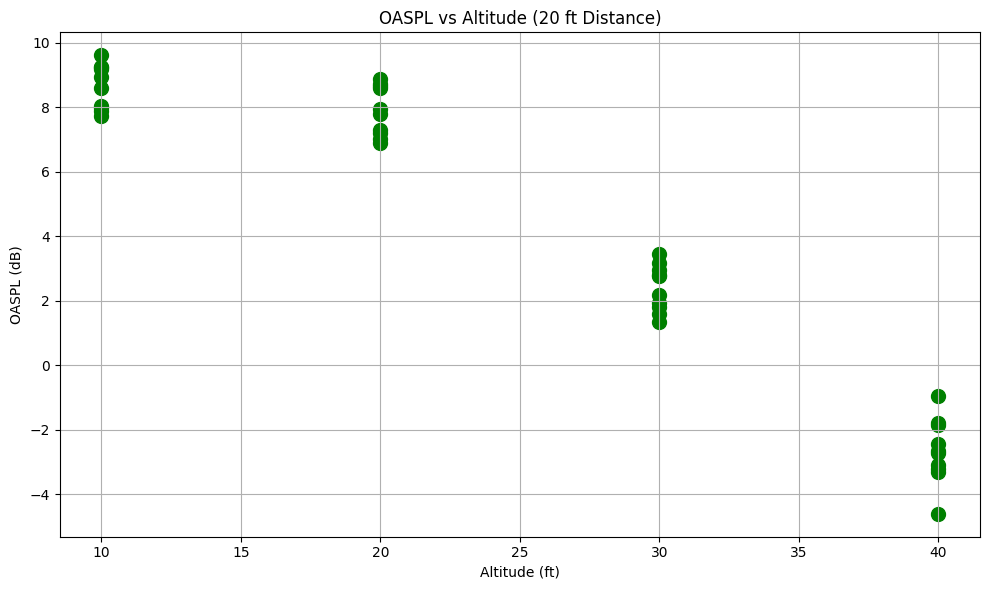

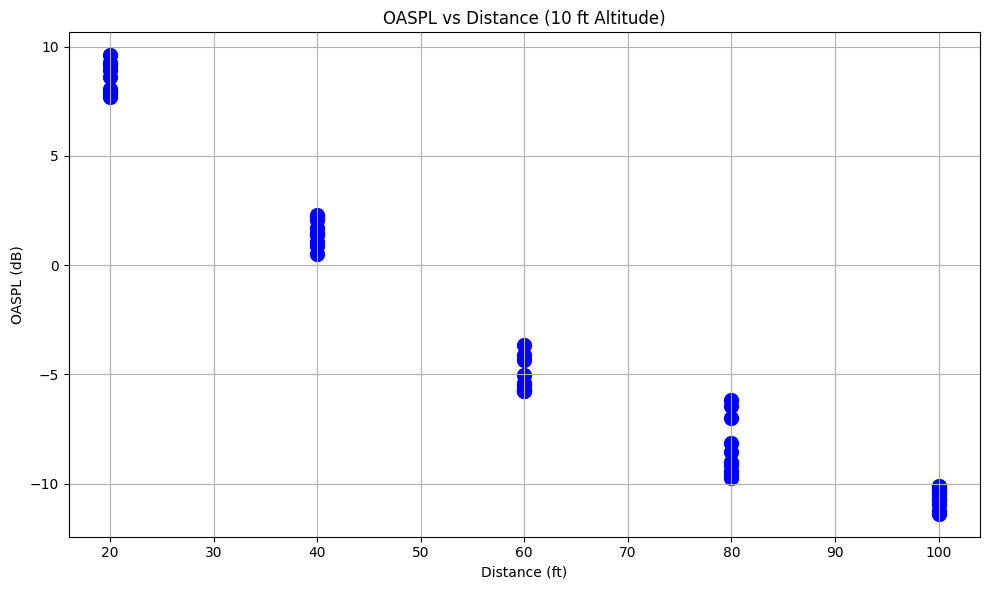

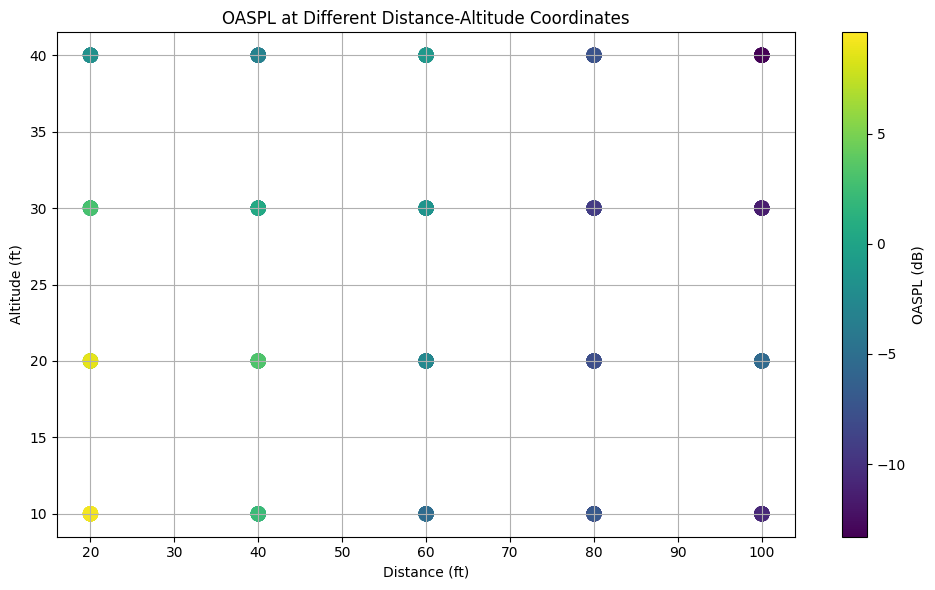

In [26]:
import os
import numpy as np
import soundfile as sf
import scipy.signal as signal
import matplotlib.pyplot as plt

def read_calibration_file(calibration_path):
    """
    Reads the UMIK-1 calibration file (frequency in Hz and dB correction).
    Returns interpolating function for calibration.
    """
    # Load calibration file data
    data = np.loadtxt(calibration_path, skiprows=1)  # Skip first row with Sens Factor
    freq, correction = data[:, 0], data[:, 1]
    # Interpolation for calibration curve
    calibration_interp = np.interp
    return lambda f: calibration_interp(f, freq, correction)

def compute_spl_db(fft_magnitude, ref=20e-6):
    """
    Convert magnitude to SPL in dB. ref is 20 µPa.
    """
    return 20 * np.log10(fft_magnitude / ref + 1e-20)  # Avoid log(0)

def process_audio_file(wav_path, calibration_path):
    # Load audio file
    data, samplerate = sf.read(wav_path)
    
    # If stereo, convert to mono
    if data.ndim > 1:
        data = np.mean(data, axis=1)

    # Apply a Hann window
    window = np.hanning(len(data))
    data_windowed = data * window

    # FFT
    fft_result = np.fft.rfft(data_windowed)
    freqs = np.fft.rfftfreq(len(data), 1/samplerate)
    fft_magnitude = np.abs(fft_result) / len(data_windowed)

    # Load and interpolate calibration correction
    calib_func = read_calibration_file(calibration_path)
    calib_correction_db = calib_func(freqs)

    # Convert to SPL in dB
    spl = compute_spl_db(fft_magnitude)
    spl_calibrated = spl + calib_correction_db  # Apply calibration

    return freqs, spl_calibrated

def calculate_oaspl(spl_calibrated):
    """
    Calculates the Overall Sound Pressure Level (OASPL) from the SPL data.
    This is an average SPL across the frequency spectrum.
    """
    # OASPL is essentially the average SPL across all frequencies
    oaspl = np.mean(spl_calibrated)
    return oaspl

def plot_oaspl(oaspl_values, coordinates):
    """
    Plot the OASPL values on a 2D scatter plot with distance and altitude as axes.
    """
    distances, altitudes = zip(*coordinates)
    plt.figure(figsize=(10, 6))
    plt.scatter(distances, altitudes, c=oaspl_values, cmap='viridis', s=100)
    plt.colorbar(label="OASPL (dB)")
    plt.xlabel('Distance (ft)')
    plt.ylabel('Altitude (ft)')
    plt.title('OASPL at Different Distance-Altitude Coordinates')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_oaspl_vs_distance(oaspl_values, distances):
    """
    Plot OASPL vs Distance for 10 ft altitude (scatter plot without lines).
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(distances, oaspl_values, color='blue', s=100)
    plt.xlabel('Distance (ft)')
    plt.ylabel('OASPL (dB)')
    plt.title('OASPL vs Distance (10 ft Altitude)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_oaspl_vs_altitude(oaspl_values, altitudes):
    """
    Plot OASPL vs Altitude for 20 ft distance (scatter plot without lines).
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(altitudes, oaspl_values, color='green', s=100)
    plt.xlabel('Altitude (ft)')
    plt.ylabel('OASPL (dB)')
    plt.title('OASPL vs Altitude (20 ft Distance)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Usage ===
calibration_file = r"D:\FYP\Final Project\calibration_file.txt"  # Path to the calibration file
audio_folder = r"D:\FYP\Final Project\clean_audio_files"  # Folder containing the audio files

# Get all the .wav files in the directory
wav_files = [f for f in os.listdir(audio_folder) if f.endswith('.wav')]

# Variables to store the OASPL values and their corresponding coordinates
oaspl_values = []
coordinates = []

# Process each audio file
for wav_file in wav_files:
    # Extract distance and altitude from the filename (e.g., DroneA_d20_h10_seg2.wav)
    parts = wav_file.split('_')
    distance = int(parts[1][1:])  # Distance is after 'd' in the filename
    altitude = int(parts[2][1:])  # Altitude is after 'h' in the filename
    
    # Construct the full path of the audio file
    wav_path = os.path.join(audio_folder, wav_file)
    
    # Process the audio file and calculate OASPL
    freqs, spl_calibrated = process_audio_file(wav_path, calibration_file)
    oaspl = calculate_oaspl(spl_calibrated)
    
    # Store the OASPL value and coordinates
    oaspl_values.append(oaspl)
    coordinates.append((distance, altitude))

# Filter the data for the plot
# Plot OASPL vs Altitude for 20 ft distance
filtered_oaspl_values_altitude = [oaspl_values[i] for i in range(len(coordinates)) if coordinates[i][0] == 20]
filtered_altitudes = [coordinates[i][1] for i in range(len(coordinates)) if coordinates[i][0] == 20]
plot_oaspl_vs_altitude(filtered_oaspl_values_altitude, filtered_altitudes)

# Plot OASPL vs Distance for 10 ft altitude
filtered_oaspl_values_distance = [oaspl_values[i] for i in range(len(coordinates)) if coordinates[i][1] == 10]
filtered_distances = [coordinates[i][0] for i in range(len(coordinates)) if coordinates[i][1] == 10]
plot_oaspl_vs_distance(filtered_oaspl_values_distance, filtered_distances)

# Plot the OASPL results for all coordinates (Distance vs Altitude)
plot_oaspl(oaspl_values, coordinates)
